# Create Tables for Evidence

Create tables sumarizing evidence for RBC-GEM reconstruction components.
## Setup
### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
from rbc_gem_utils import (
    ANNOTATION_PATH,
    CURATION_PATH,
    EXTERNAL_PATH,
    INTERIM_PATH,
    ROOT_PATH,
    build_string,
    compare_tables,
    get_annotation_df,
    read_rbc_model,
    show_versions,
    split_string,
    visualize_comparison,
)

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM model

In [2]:
model = read_rbc_model(filetype="xml")
model.reactions.sort()
model.genes.sort()
model.metabolites.sort()
model

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21


Name,RBC_GEM
Memory address,15334e710
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Load omic evidence
### Proteomic evidence

In [3]:
df_proteomic_evidence = pd.read_csv(
    ROOT_PATH / EXTERNAL_PATH / "proteomics" / "proteomic_evidence_table.tsv",
    sep="\t",
    index_col=0,
)
df_proteomic_evidence = pd.concat(
    (
        df_proteomic_evidence.sum(axis=1),
        pd.DataFrame.from_dict(
            {
                uniprot_id: build_string(
                    sorted(
                        [
                            f"{pubmed}"
                            for pubmed, is_detected in value_dict.items()
                            if bool(is_detected)
                        ]
                    )
                )
                for uniprot_id, value_dict in df_proteomic_evidence.T.to_dict().items()
            },
            orient="index",
        ),
    ),
    axis=1,
)
df_proteomic_evidence.columns = [
    "proteomic evidence (#studies)",
    "proteomic evidence (pubmed)",
]
df_proteomic_evidence

,proteomic evidence (#studies),proteomic evidence (pubmed)
P04406,28,pubmed:12362340;pubmed:14963112;pubmed:1686133...
P11142,26,pubmed:12362340;pubmed:14963112;pubmed:1686133...
P00915,25,pubmed:14963112;pubmed:16861337;pubmed:1849451...
Q00013,25,pubmed:12362340;pubmed:14963112;pubmed:1686133...
P25787,24,pubmed:12362340;pubmed:14963112;pubmed:1686133...
...,...,...
Q8NBI6,1,pubmed:28689405
Q8NBF6,1,pubmed:38964323
Q8NB78,1,pubmed:33103907
P30084,1,pubmed:37942280


### Create evidence tables

In [4]:
compare = True
overwrite = True
compare_figsize = (5, 5)

#### Metabolites

,metabolites,metabolite,name,formula,charge,compartment,metabolomic evidence (#studies),metabolomic evidence (pubmed),references,notes
0,10fthf_c,10fthf,10-formyl-tetrahydrofolate,C20H21N7O7,-2,c,<NA>,<NA>,<NA>,<NA>
1,12ppd__R_c,12ppd__R,"(R)-propane-1,2-diol",C3H8O2,0,c,<NA>,<NA>,<NA>,<NA>
2,12ppd__S_c,12ppd__S,"(S)-propane-1,2-diol",C3H8O2,0,c,<NA>,<NA>,<NA>,<NA>
3,13dampp_c,13dampp,"1,3-diaminopropane",C3H12N2,2,c,<NA>,<NA>,<NA>,<NA>
4,13dpg_c,13dpg,3-Phospho-D-glyceroyl phosphate,C3H4O10P2,-4,c,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...
2152,zn2_c,zn2,Zinc (II),Zn,2,c,<NA>,<NA>,<NA>,<NA>
2153,zn2_e,zn2,Zinc (II),Zn,2,e,<NA>,<NA>,<NA>,<NA>
2154,ztp_c,ztp,5-amino-4-imidazolecarboxamide riboside 5'-tri...,C9H13N4O14P3,-4,c,<NA>,<NA>,<NA>,<NA>
2155,zymst_c,zymst,zymosterol,C27H44O,0,c,<NA>,<NA>,<NA>,<NA>


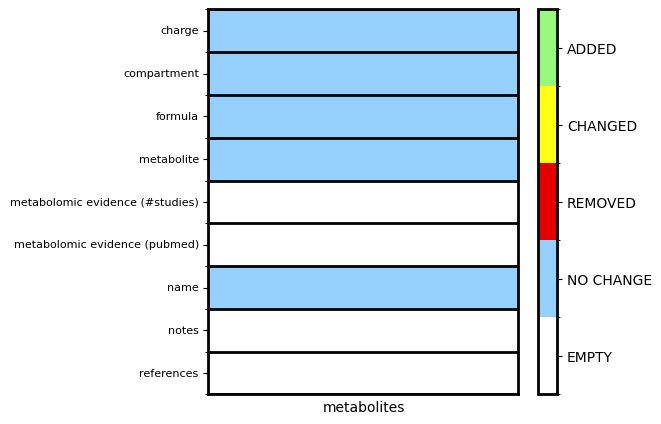

In [5]:
attribute_type = "metabolites"
try:
    df_previous = pd.read_csv(
        ROOT_PATH / CURATION_PATH / f"{attribute_type}_evidence.tsv",
        sep="\t",
        index_col=None,
    )
    df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
except FileNotFoundError:
    df_previous = pd.DataFrame([], columns=[attribute_type])

df_evidence = pd.DataFrame.from_dict(
    {
        idx: {
            "metabolites": metabolite.id,
            "metabolite": metabolite.id.replace(f"_{metabolite.compartment}", ""),
            "name": metabolite.name,
            "formula": metabolite.formula,
            "charge": metabolite.charge,
            "compartment": metabolite.compartment,
            "metabolomic evidence (#studies)": "",  # TODO
            "metabolomic evidence (pubmed)": "",  # TODO
        }
        for idx, metabolite in enumerate(model.metabolites)
    },
    orient="index",
)
df_evidence = df_evidence.set_index(attribute_type)
df_evidence["references"] = df_previous.set_index(attribute_type)["references"]
df_evidence["references"] = (
    df_evidence["references"]
    .fillna("")
    .apply(lambda x: build_string(sorted(split_string(x))))
)
df_evidence["notes"] = df_previous.set_index(attribute_type)["notes"]
df_evidence = df_evidence.reset_index(drop=False).sort_values(
    by=["metabolomic evidence (#studies)", attribute_type, "compartment"],
    ascending=[False, True, True],
)
df_evidence = df_evidence.reset_index(drop=True)
df_evidence = df_evidence.replace(float("nan"), pd.NA).replace("", pd.NA)
df_references = df_evidence[[attribute_type, "references"]].copy()

if compare:
    compare_on_index = [attribute_type]
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index), df_evidence.set_index(compare_on_index)
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if overwrite:
    df_evidence.to_csv(
        ROOT_PATH / CURATION_PATH / f"{attribute_type}_evidence.tsv",
        sep="\t",
        index=False,
    )
    df_references.to_csv(
        ROOT_PATH / ANNOTATION_PATH / f"{attribute_type}_References.tsv",
        sep="\t",
        index=False,
    )
else:
    df_evidence.to_csv(
        ROOT_PATH / INTERIM_PATH / f"{attribute_type}_evidence.tsv",
        sep="\t",
        index=False,
    )
    df_references.to_csv(
        ROOT_PATH / INTERIM_PATH / f"{attribute_type}_References.tsv",
        sep="\t",
        index=False,
    )
df_evidence

#### Genes

,genes,uniprot,ncbigene,hgnc.symbol,proteomic evidence (#studies),proteomic evidence (pubmed),references,notes
0,GAPDH,P04406,2597,GAPDH,28,pubmed:12362340;pubmed:14963112;pubmed:1686133...,pubmed:19430704,<NA>
1,HSPA8,P11142,3312,HSPA8,26,pubmed:12362340;pubmed:14963112;pubmed:1686133...,pubmed:33832207,<NA>
2,CA1,P00915,759,CA1,25,pubmed:14963112;pubmed:16861337;pubmed:1849451...,pubmed:10090333;pubmed:4958988;pubmed:4975695,<NA>
3,ALDH1A1,P00352,216,ALDH1A1,24,pubmed:16861337;pubmed:18399644;pubmed:1849451...,pubmed:17175089;pubmed:224930;pubmed:2776714;p...,<NA>
4,BLVRB,P30043,645,BLVRB,24,pubmed:12362340;pubmed:14963112;pubmed:1861456...,pubmed:10858451;pubmed:34598;pubmed:8117274,<NA>
...,...,...,...,...,...,...,...,...
815,SMPD3,Q9NY59,55512,SMPD3,0,<NA>,pubmed:22824271;pubmed:25075126,pubmed:25075126;pubmed:22824271
816,ST3GAL1,Q11201,6482,ST3GAL1,0,<NA>,pubmed:3084191;pubmed:5003667,<NA>
817,ST3GAL2,Q16842,6483,ST3GAL2,0,<NA>,pubmed:3084191;pubmed:5003667,<NA>
818,TRPC6,Q9Y210,7225,TRPC6,0,<NA>,pubmed:18209485,<NA>


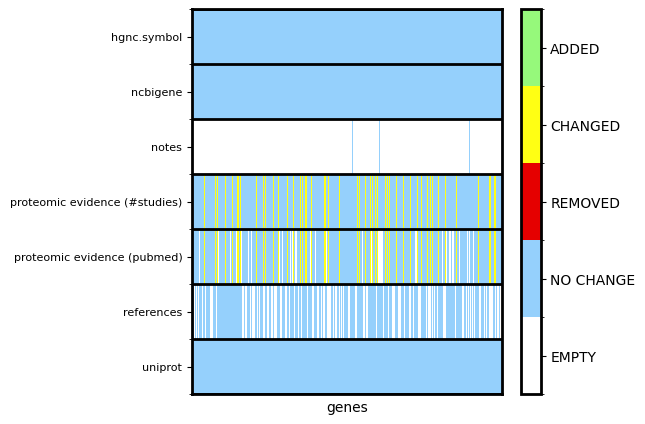

In [6]:
attribute_type = "genes"
try:
    df_previous = pd.read_csv(
        ROOT_PATH / CURATION_PATH / f"{attribute_type}_evidence.tsv",
        sep="\t",
        index_col=None,
    )
    df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
except FileNotFoundError:
    df_previous = pd.DataFrame([], columns=[attribute_type])

annotation_cols = ["uniprot", "ncbigene", "hgnc.symbol"]
df_evidence = get_annotation_df(getattr(model, attribute_type), annotation_cols)
df_evidence = df_evidence.rename({"id": attribute_type}, axis=1).set_index(
    attribute_type
)
df_evidence = df_evidence.merge(
    df_proteomic_evidence,
    left_on="uniprot",
    right_index=True,
    how="left",
)
df_evidence["proteomic evidence (#studies)"] = (
    df_evidence["proteomic evidence (#studies)"].fillna(0).astype(int)
)

df_evidence["references"] = df_previous.set_index(attribute_type)["references"]
df_evidence["references"] = (
    df_evidence["references"]
    .fillna("")
    .apply(lambda x: build_string(sorted(split_string(x))))
)
df_evidence["notes"] = df_previous.set_index(attribute_type)["notes"]
df_evidence = df_evidence.reset_index(drop=False).sort_values(
    by=["proteomic evidence (#studies)", attribute_type], ascending=[False, True]
)
df_evidence = df_evidence.reset_index(drop=True)
df_evidence = df_evidence.replace(float("nan"), pd.NA).replace("", pd.NA)
df_references = df_evidence[[attribute_type, "references"]].copy()

if compare:
    compare_on_index = [attribute_type]
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index), df_evidence.set_index(compare_on_index)
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if overwrite:
    df_evidence.to_csv(
        ROOT_PATH / CURATION_PATH / f"{attribute_type}_evidence.tsv",
        sep="\t",
        index=False,
    )
    df_references.to_csv(
        ROOT_PATH / ANNOTATION_PATH / f"{attribute_type}_References.tsv",
        sep="\t",
        index=False,
    )
else:
    df_evidence.to_csv(
        ROOT_PATH / INTERIM_PATH / f"{attribute_type}_evidence.tsv",
        sep="\t",
        index=False,
    )
    df_references.to_csv(
        ROOT_PATH / INTERIM_PATH / f"{attribute_type}_References.tsv",
        sep="\t",
        index=False,
    )

model_proteomics_count = df_evidence.set_index("genes")[
    "proteomic evidence (#studies)"
].to_dict()
df_evidence

#### Reactions

,reactions,name,reaction,gene reaction rule,subsystem,spontaneous,proteomic evidence (#studies),references,notes
0,5FLUDPK,Nucleoside-diphosphate kinase (ATP:5-fluorouri...,5fludp_c + atp_c --> 5flutp_c + adp_c,NME1 or (NME1 and NME2) or NME2 or (NME1 and N...,5-fluorouracil metabolism,0,NME1(17);NME2(12);NME3(1),<NA>,<NA>
1,5FLUMPK,Uridylate kinase (ATP:5-fluorouridine 5-monoph...,5flump_c + atp_c --> 5fludp_c + adp_c,CMPK1,5-fluorouracil metabolism,0,CMPK1(13),<NA>,<NA>
2,5FLURAPT,5-fluorouracil phosphoribosyltransferase,5flura_c + prpp_c --> 5flump_c + ppi_c,UMPS,5-fluorouracil metabolism,0,UMPS(7),<NA>,<NA>
3,D5FURADy,"5,6-dihydro-5-fluorouracil:NADP + 5-oxidoreduc...",5flura_c + h_c + nadph_c --> 56dh5flura_c + na...,DPYD,5-fluorouracil metabolism,0,DPYD(1),<NA>,<NA>
4,FACOAE_10_0,Acyl CoA thioesterase (CoA 10:0),FAcoa_hs_10_0_c + h2o_c --> FA_hs_10_0_c + coa...,ACOT7,Acyl-CoA hydrolysis,0,ACOT7(14),pubmed:10578051;pubmed:5042454,<NA>
...,...,...,...,...,...,...,...,...,...
2718,PYDXPPe,Pyridoxal 5-phosphate phosphatase,h2o_e + pydx5p_e --> pi_e + pydx_e,ALPL,Vitamin B6 metabolism,0,<NA>,pubmed:1322411;pubmed:14522954;pubmed:7448195;...,<NA>
2719,AVITE1RASCBR1,Reduction of alpha-tocopherol radical via L-as...,ascb__L_c + avite1r_c <=> avite1_c + mdhdascb_...,<NA>,Vitamin E metabolism,1,<NA>,pubmed:18243141;pubmed:36643550;pubmed:8388377...,<NA>
2720,AVITE1RCYTB5R,Reduction of alpha-tocopherol radical via L-as...,avite1r_c + focytb5_c + h_c --> avite1_c + fic...,(CYB5R3 and CYB5B) or (CYB5R3 and CYB5A),Vitamin E metabolism,0,CYB5A(13);CYB5B(8);CYB5R3(20),pubmed:8388377,<NA>
2721,AVITE1RQ10H2R,Reduction of alpha-tocopherol radical via ubiq...,avite1r_c + q10h2_c --> avite1_c + q10h_c,<NA>,Vitamin E metabolism,1,<NA>,pubmed:8388377;pubmed:8434935,<NA>


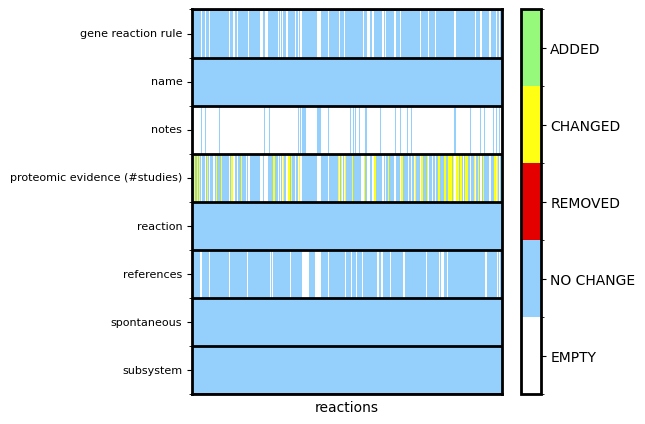

In [7]:
attribute_type = "reactions"
try:
    df_previous = pd.read_csv(
        ROOT_PATH / CURATION_PATH / f"{attribute_type}_evidence.tsv",
        sep="\t",
        index_col=None,
    )
    df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
except FileNotFoundError:
    df_previous = pd.DataFrame([], columns=[attribute_type])

df_evidence = pd.DataFrame.from_dict(
    {
        idx: {
            "reactions": reaction.id,
            "name": reaction.name,
            "reaction": reaction.reaction,
            "gene reaction rule": reaction.gene_reaction_rule,
            "subsystem": reaction.subsystem,
            "spontaneous": reaction.annotation.get("spontaneous", 0),
            "proteomic evidence (#studies)": build_string(
                sorted(
                    [
                        "{}({})".format(gene.id, model_proteomics_count[gene.id])
                        for gene in list(reaction.genes)
                        if model_proteomics_count[gene.id] != 0
                    ]
                )
            ),
        }
        for idx, reaction in enumerate(
            model.reactions.query(lambda x: not x.subsystem in {"Pseudoreactions"})
        )
    },
    orient="index",
)
df_evidence = df_evidence.set_index(attribute_type)
# Preserve reactions marked spontaneous based on reference data
df_evidence["spontaneous"] = df_previous.set_index(attribute_type)["spontaneous"]
df_evidence["references"] = df_previous.set_index(attribute_type)["references"]
df_evidence["references"] = (
    df_evidence["references"]
    .fillna("")
    .apply(lambda x: build_string(sorted(split_string(x))))
)
df_evidence["notes"] = df_previous.set_index(attribute_type)["notes"]
df_evidence = df_evidence.reset_index(drop=False).sort_values(
    by=["subsystem", "reactions"], ascending=[True, True]
)
df_evidence = df_evidence.reset_index(drop=True)
df_evidence = df_evidence.replace(float("nan"), pd.NA).replace("", pd.NA)
df_references = df_evidence[[attribute_type, "references"]].copy()

if compare:
    compare_on_index = [attribute_type]
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index), df_evidence.set_index(compare_on_index)
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if overwrite:
    df_evidence.to_csv(
        ROOT_PATH / CURATION_PATH / f"{attribute_type}_evidence.tsv",
        sep="\t",
        index=False,
    )
    df_references.to_csv(
        ROOT_PATH / ANNOTATION_PATH / f"{attribute_type}_References.tsv",
        sep="\t",
        index=False,
    )
else:
    df_evidence.to_csv(
        ROOT_PATH / INTERIM_PATH / f"{attribute_type}_evidence.tsv",
        sep="\t",
        index=False,
    )
    df_references.to_csv(
        ROOT_PATH / INTERIM_PATH / f"{attribute_type}_References.tsv",
        sep="\t",
        index=False,
    )
df_evidence

In [8]:
set1 = set(
    df_evidence[df_evidence["references"].isna()].loc[:, attribute_type].unique()
)
set2 = set(
    df_evidence[df_evidence["references"].notna()].loc[:, attribute_type].unique()
)
set3 = set(
    df_evidence[df_evidence["proteomic evidence (#studies)"].isna()]
    .loc[:, attribute_type]
    .unique()
)
set4 = set(
    df_evidence[df_evidence["proteomic evidence (#studies)"].notna()]
    .loc[:, attribute_type]
    .unique()
)
set5 = set(df_evidence[df_evidence["spontaneous"] == 1].loc[:, attribute_type].unique())
assert len(df_evidence) == len(set1.union(set2).union(set3).union(set4).union(set5))
print(f"Known spontaneous: {len(set1.intersection(set3).intersection(set5))}")
print(f"No clear evidence: {len(set1.intersection(set3).difference(set5))}")
print(f"Only omic evidence: {len(set1.intersection(set4))}")
print(f"Only lit. evidence: {len(set2.intersection(set3))}")
print(f"Both evidence types: {len(set2.intersection(set4))}")
print(f"Total {attribute_type}: {len(df_evidence)}")

Known spontaneous: 7
No clear evidence: 100
Only omic evidence: 322
Only lit. evidence: 543
Both evidence types: 1751
Total reactions: 2723
